In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Siamese/Localization'

/content/drive/My Drive/Siamese/Localization


In [3]:
import sys
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')
sys.path.insert(0, '..')

In [4]:
!pip install torchaudio
!pip install pyroomacoustics==0.3.1
!pip install cookiecutter

In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 10

torch.backends.cudnn.deterministic = True
B = 8

WEIGHT_DECAY = 5e-4
LR_INIT = 1e-2
LR_LAST = 1e-4
# lr scheduler parameter
gamma = 10 ** (np.log10(LR_LAST / LR_INIT) / (EPOCH_NUM - 1))
MOMENTUM = 0.9
NUM_WORKERS = 4

NUM_CLASSES = 10

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

trainset = IdentificationDataset(DATASET_PATH, 
                                 NUM_CLASSES,
                                 train=True, 
                                 transform=transforms,
                                 lenght=1,
                                 return_type=ReturnType.STANDARD)
trainsetloader = torch.utils.data.DataLoader(trainset, 
                                             batch_size=B, 
                                             num_workers=NUM_WORKERS, 
                                             shuffle=True)

testset = IdentificationDataset(DATASET_PATH, 
                                NUM_CLASSES,
                                train=False, 
                                transform=transforms,
                                lenght=1,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=B, 
                                            num_workers=NUM_WORKERS)

print("lenght train loader ", len(trainsetloader))
print("lenght test loader ", len(testsetloader))


sample lenght  1
sample lenght  1
lenght train loader  129
lenght test loader  144


In [8]:
from LocateEncoder import LocateEncoder

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = LocateEncoder(final_size=16)

net.to(DEVICE)

LocateEncoder(
  (conv1): Conv1DBlock(
    (conv): Conv1d(1, 4, kernel_size=(5,), stride=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv1DBlock(
    (conv): Conv1d(4, 16, kernel_size=(5,), stride=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Conv1DBlock(
    (conv1): Conv1d(16, 4, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(16, 12, kernel_size=(5,), stride=(1,), padding=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Conv1DBlock(
    (conv1): Conv1d(16, 4, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(16, 12, kernel_size=(5,), stride=(1,), padding=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Conv1DBlock(
    (conv1): Conv1d(16, 4, kernel_size=

In [9]:
import numpy as np
from Room import Room

optimizer = optim.SGD(net.parameters(), LR_INIT, MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

max_accuracy = 0
test_accuracy = []
train_accuracy = []

train_losses = []
test_losses = []

for epoch_num in range(EPOCH_NUM):
    train_loss = 0
    test_loss = 0
    print("*** Epoch ", epoch_num, " ***")
    lr_scheduler.step()
    
    # train
    print("*** Train ***")
    net.train()

    accuracy = 0
    nb_test = 0
    
    for iter_num, (_, samples) in tqdm(enumerate(trainsetloader)):
      # Create a room
      room = Room()
      # Add samples in room
      for sample in samples:
        room.addsource(sample)
      # Get mics
      sample1, sample2 = room()
      sample1 = sample1.to(DEVICE)
      sample2 = sample2.to(DEVICE)
      optimizer.zero_grad()
      # Send mics to network
      results, loss = net(sample1, sample2)
      # Learn
      loss.backward()
      # Store loss and accuracy
      train_loss += loss.item()
      accuracy += results.mean()
      optimizer.step()

    train_loss /= len(trainsetloader)
    print("Train loss ", train_loss)
    train_losses.append(train_loss)
    accuracy /= len(trainsetloader)
    print("Train accuracy ", accuracy)
    train_accuracy.append(accuracy)
    
    # test
    net.eval()
    print("*** Test ***")
    
    accuracy = 0
    nb_test = 0
    loss = 0

    for iter_num, (_, samples) in tqdm(enumerate(testsetloader)):
      # Create a room
      room = Room()
      # Add samples in room
      for sample in samples:
        room.addsource(sample)
      # Get mics
      sample1, sample2 = room()
      sample1 = sample1.to(DEVICE)
      sample2 = sample2.to(DEVICE)
      # Send mics to network
      results, loss = net(sample1, sample2)
      # Store loss and accuracy
      test_loss += loss.item()
      accuracy += results.mean()

    test_loss /= len(testsetloader)
    print("Test loss ", test_loss)
    test_losses.append(test_loss)
    accuracy /= len(testsetloader)
    print("Test accuracy ", accuracy)
    test_accuracy.append(accuracy)

    if accuracy > max_accuracy:
      net.store_encoder()



*** Epoch  0  ***
*** Train ***


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
129it [01:35,  1.35it/s]

Train loss  88.62196174518083
Train accuracy  tensor(0.9368, device='cuda:0')
*** Test ***



144it [01:13,  1.95it/s]


Test loss  66.09039096037547
Test accuracy  tensor(0.9533, device='cuda:0')
*** Epoch  1  ***
*** Train ***


129it [01:18,  1.63it/s]

Train loss  58.99604080259338
Train accuracy  tensor(0.9564, device='cuda:0')
*** Test ***



144it [00:45,  3.13it/s]


Test loss  53.88811827368207
Test accuracy  tensor(0.9588, device='cuda:0')
*** Epoch  2  ***
*** Train ***


129it [01:19,  1.62it/s]

Train loss  51.03967375718346
Train accuracy  tensor(0.9626, device='cuda:0')
*** Test ***



144it [00:46,  3.11it/s]


Test loss  56.27291116780705
Test accuracy  tensor(0.9607, device='cuda:0')
*** Epoch  3  ***
*** Train ***


129it [01:19,  1.62it/s]

Train loss  48.80778523101363
Train accuracy  tensor(0.9623, device='cuda:0')
*** Test ***



144it [00:45,  3.14it/s]


Test loss  46.03663925329844
Test accuracy  tensor(0.9657, device='cuda:0')
*** Epoch  4  ***
*** Train ***


129it [01:18,  1.64it/s]

Train loss  45.87444364192874
Train accuracy  tensor(0.9651, device='cuda:0')
*** Test ***



144it [00:45,  3.14it/s]


Test loss  43.86157282193502
Test accuracy  tensor(0.9673, device='cuda:0')
*** Epoch  5  ***
*** Train ***


129it [01:19,  1.63it/s]

Train loss  43.40281268792559
Train accuracy  tensor(0.9668, device='cuda:0')
*** Test ***



144it [00:46,  3.12it/s]


Test loss  43.10360869516929
Test accuracy  tensor(0.9683, device='cuda:0')
*** Epoch  6  ***
*** Train ***


129it [01:18,  1.64it/s]

Train loss  42.341346448706105
Train accuracy  tensor(0.9673, device='cuda:0')
*** Test ***



144it [00:45,  3.13it/s]


Test loss  42.570638881789314
Test accuracy  tensor(0.9677, device='cuda:0')
*** Epoch  7  ***
*** Train ***


129it [01:18,  1.64it/s]

Train loss  46.620906523031785
Train accuracy  tensor(0.9646, device='cuda:0')
*** Test ***



144it [00:46,  3.11it/s]


Test loss  41.48323131394055
Test accuracy  tensor(0.9678, device='cuda:0')
*** Epoch  8  ***
*** Train ***


129it [01:19,  1.62it/s]

Train loss  44.41967680287916
Train accuracy  tensor(0.9656, device='cuda:0')
*** Test ***



144it [00:45,  3.13it/s]


Test loss  44.48666437632508
Test accuracy  tensor(0.9675, device='cuda:0')
*** Epoch  9  ***
*** Train ***


129it [01:18,  1.64it/s]

Train loss  42.27810339779817
Train accuracy  tensor(0.9672, device='cuda:0')
*** Test ***



144it [00:45,  3.16it/s]


Test loss  43.04916054010391
Test accuracy  tensor(0.9680, device='cuda:0')


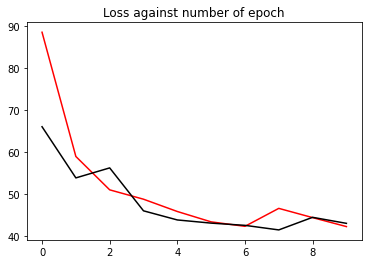

In [10]:
import matplotlib.pyplot as plt

plt.title("Loss against number of epoch")
plt.plot([i for i in range(EPOCH_NUM)], train_losses , label='Train loss', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_losses , label='Test loss', color='black')


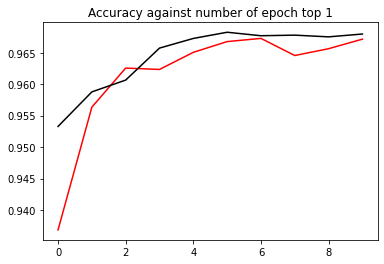

In [11]:
plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], train_accuracy , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_accuracy , label='test 1', color='black')
